In [8]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import cv2
from sklearn.naive_bayes import GaussianNB
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


## Bayes Classifier

### Load Data

In [ ]:
data_path = 'data.csv'
data = pd.read_csv(data_path)
main_folder = 'data'

def load_frames(video_id):
    folder = os.path.join(main_folder, str(video_id))
    frames = []
    for img in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, img)
        img = Image.open(img_path)
        frames.append(np.array(img).flatten())
    return np.array(frames).flatten()  

features = []
labels = []
for index, row in data.iterrows():
    video_id = row['video_id']
    label_id = row['label_id']
    feature_vector = load_frames(video_id)
    features.append(feature_vector)
    labels.append(label_id)

X = np.array(features)
y = np.array(labels)

### Train Test Split

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Define Classifier

In [9]:
class BayesClassifier:
    def __init__(self, x, y):
        self.x = x  
        self.y = y 
        self.classes = np.unique(y) 
        self.num_classes = len(self.classes) 
        self.class_stats = {cls: {'mean': None, 'var': None, 'prior': None} for cls in self.classes}

    def fit(self):
        for cls in self.classes:
            x_cls = self.x[self.y == cls]  
            class_mean = np.mean(x_cls, axis=0)
            class_var = np.var(x_cls, axis=0) + 1e-6 
            class_prior = x_cls.shape[0] / self.x.shape[0]

            self.class_stats[cls]['mean'] = class_mean
            self.class_stats[cls]['var'] = class_var
            self.class_stats[cls]['prior'] = class_prior

    def predict(self, x):
        log_posteriors = []
        for cls in self.classes:
            mean = self.class_stats[cls]['mean']
            var = self.class_stats[cls]['var']
            prior = self.class_stats[cls]['prior']

            log_likelihood = -0.5 * np.sum(((x - mean) ** 2) / var + np.log(2 * np.pi * var), axis=1)
            log_posterior = log_likelihood + np.log(prior)
            log_posteriors.append(log_posterior)

        log_posteriors = np.column_stack(log_posteriors)
        return np.argmax(log_posteriors, axis=1)

### Fit Model

In [ ]:
bayes = BayesClassifier(X_train, y_train)
bayes.fit()

In [ ]:
pred = bayes.predict(X_val)

              precision    recall  f1-score   support

           0       0.16      0.21      0.18       211
           1       0.15      0.21      0.18       205
           2       0.15      0.09      0.11       196
           3       0.09      0.05      0.06       213
           4       0.13      0.33      0.18       193
           5       0.13      0.04      0.07       206
           6       0.15      0.07      0.10       210
           7       0.17      0.14      0.15       215

    accuracy                           0.14      1649
   macro avg       0.14      0.14      0.13      1649
weighted avg       0.14      0.14      0.13      1649

14.06913280776228


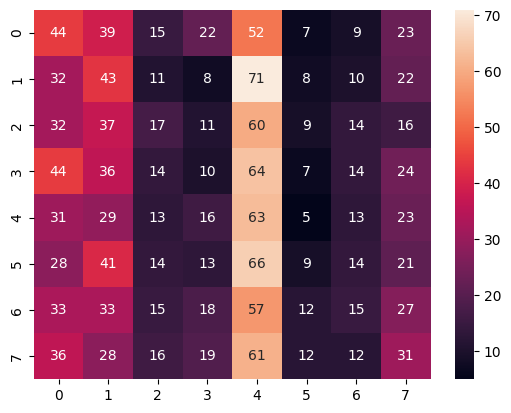

In [13]:
score = accuracy_score(y_val, pred)
report = classification_report(y_val, pred)
cm = confusion_matrix(y_val, pred)

print(report)
print(score * 100)
sns.heatmap(cm, annot=True)
plt.show()

## Bayes Classifier with Normalization

### Load Data

In [14]:
data_path = 'data.csv'
data = pd.read_csv(data_path)
main_folder = 'data'

def load_frames(video_id):
    folder = os.path.join(main_folder, str(video_id))
    frames = []
    for img in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, img)
        img = Image.open(img_path)
        img = np.array(img) / 255
        frames.append(img.flatten())
    return np.array(frames).flatten()  

features = []
labels = []
for index, row in data.iterrows():
    video_id = row['video_id']
    label_id = row['label_id']
    feature_vector = load_frames(video_id)
    features.append(feature_vector)
    labels.append(label_id)

X = np.array(features)
y = np.array(labels)

### Train Test Split

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Fit Model

In [16]:
bayes = BayesClassifier(X_train, y_train)
bayes.fit()

### Prediction

In [17]:
pred = bayes.predict(X_val)

              precision    recall  f1-score   support

           0       0.15      0.19      0.16       198
           1       0.12      0.19      0.14       214
           2       0.15      0.09      0.11       200
           3       0.09      0.02      0.03       187
           4       0.20      0.38      0.27       212
           5       0.15      0.15      0.15       216
           6       0.10      0.10      0.10       212
           7       0.16      0.04      0.07       210

    accuracy                           0.15      1649
   macro avg       0.14      0.15      0.13      1649
weighted avg       0.14      0.15      0.13      1649

14.736203759854458


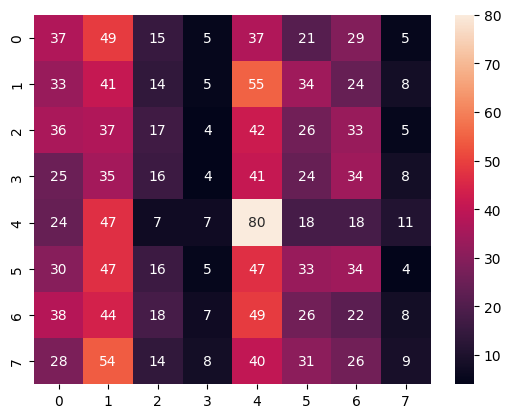

In [18]:
score = accuracy_score(y_val, pred)
report = classification_report(y_val, pred)
cm = confusion_matrix(y_val, pred)

print(report)
print(score * 100)
sns.heatmap(cm, annot=True)
plt.show()

## Bayes Classifier on Gray Scale

### Load Data

In [20]:
data_path = 'data.csv'
data = pd.read_csv(data_path)
main_folder = 'data'

def load_frames(video_id):
    folder = os.path.join(main_folder, str(video_id))
    frames = []
    for img in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, img)
        img = Image.open(img_path).convert('L')
        frames.append(np.array(img).flatten())
    return np.array(frames).flatten()  

features = []
labels = []
for index, row in data.iterrows():
    video_id = row['video_id']
    label_id = row['label_id']
    feature_vector = load_frames(video_id)
    features.append(feature_vector)
    labels.append(label_id)

X = np.array(features)
y = np.array(labels)

### Train Test Split

In [21]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Fit Model

In [22]:
bayes = BayesClassifier(X_train, y_train)
bayes.fit()

### Prediction

In [23]:
pred = bayes.predict(X_val)

              precision    recall  f1-score   support

           0       0.11      0.14      0.13       207
           1       0.12      0.06      0.08       189
           2       0.13      0.08      0.10       214
           3       0.13      0.10      0.12       195
           4       0.20      0.35      0.25       206
           5       0.13      0.25      0.17       198
           6       0.16      0.12      0.14       214
           7       0.09      0.03      0.04       226

    accuracy                           0.14      1649
   macro avg       0.13      0.14      0.13      1649
weighted avg       0.13      0.14      0.13      1649

14.129775621588841


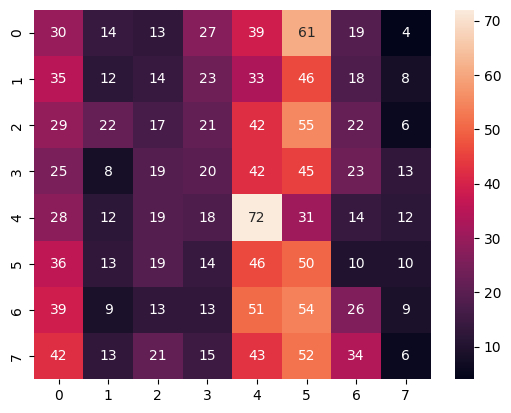

In [24]:
score = accuracy_score(y_val, pred)
report = classification_report(y_val, pred)
cm = confusion_matrix(y_val, pred)

print(report)
print(score * 100)
sns.heatmap(cm, annot=True)
plt.show()

## Bayes Classifier with LDA

### Load Data

In [3]:
def extract_features(video_id, base_path, lda):
    features = []
    folder_path = os.path.join(base_path, str(video_id))
    if os.path.exists(folder_path):
        for frame in os.listdir(folder_path):
            frame_path = os.path.join(folder_path, frame)
            img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (32, 32)) 
                features.append(img.flatten())
    
    if features:
        features = np.array(features)
        lda_features = lda.transform(features)
        lda_features = np.mean(lda_features, axis=0)
        return lda_features
    else:
        return np.zeros(lda.n_components)



In [4]:
data = pd.read_csv('data.csv')
base_path = 'data'

In [5]:
def train_lda(X, y, n_components=3):
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    lda.fit(X, y)
    return lda

all_features = []
all_labels = []
for _, row in data.iterrows():
    video_id = row['video_id']
    label = row['label_id']
    folder_path = os.path.join(base_path, str(video_id))
    if os.path.exists(folder_path):
        for frame in os.listdir(folder_path):
            frame_path = os.path.join(folder_path, frame)
            img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (32, 32))
                all_features.append(img.flatten())
                all_labels.append(label)

all_features = np.array(all_features)
all_labels = np.array(all_labels)


lda = train_lda(all_features, all_labels)


In [ ]:
data['features'] = data['video_id'].apply(lambda x: extract_features(x, base_path, lda))
X = np.vstack(data['features'].values)
y = data['label_id'].values

### Train Test Split

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Apply LDA

In [7]:
lda = LinearDiscriminantAnalysis(n_components=3) 
X_train_lda = lda.fit_transform(X_train, y_train)
X_val_lda = lda.transform(X_val)

: 

### Fit Model

In [ ]:
bayes = BayesClassifier(X_train_lda, y_train)
bayes.fit()

### Prediction

In [ ]:
pred = bayes.predict(X_val)

In [ ]:
score = accuracy_score(y_val, pred)
report = classification_report(y_val, pred)
cm = confusion_matrix(y_val, pred)

print(report)
print(f"Accuracy: {score * 100:.2f}%")
sns.heatmap(cm, annot=True)
plt.show()

In [10]:
data_path = 'data.csv'
data = pd.read_csv(data_path)
main_folder = 'data'

def load_frames(video_id):
    folder = os.path.join(main_folder, str(video_id))
    frames = []
    for img in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, img)
        img = Image.open(img_path)
        frames.append(np.array(img).flatten())
    return np.array(frames).flatten()  

features = []
labels = []
for index, row in data.iterrows():
    video_id = row['video_id']
    label_id = row['label_id']
    feature_vector = load_frames(video_id)
    features.append(feature_vector)
    labels.append(label_id)

X = np.array(features)
y = np.array(labels)

In [11]:
sffs = SFS(GaussianNB(), 
           k_features='parsimonious', 
           forward=True, 
           floating=True, 
           scoring='accuracy',
           cv=0)

sffs = sffs.fit(X, y)
X_selected = sffs.transform(X)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [ ]:
bayes = BayesClassifier(X_train, y_train)
bayes.fit()

In [ ]:
pred = bayes.predict(X_val)

In [ ]:
score = accuracy_score(y_val, pred)
report = classification_report(y_val, pred)
cm = confusion_matrix(y_val, pred)

print(report)
print(score * 100)
sns.heatmap(cm, annot=True)
plt.show()
